In [1]:
#Shishir Khanal
#Autotuning PID using Relay Feedback in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("Plots");
Pkg.add("DSP");
using ControlSystems, DSP, Plots;

    Updating registry at `C:\Users\Khanalshis\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [2]:
#Construct relay feedback system for a third order lag plant P(s) = 1 / (s + 1)³
#ZNFD requires to take the system to the brink of oscillation. Relay approach avoids this situation
begin
    s = tf("s")
    P = 1/(s+1)^3
    Ts = 0.01 #sampling time
    d = 10 #relay magnitude
    Pd = c2d(P,Ts)
end

TransferFunction{Discrete{Float64}, ControlSystemsBase.SisoRational{Float64}}
1.6542165282018573e-7z^2 + 6.567437553783861e-7z + 1.6295884519568204e-7
-------------------------------------------------------------------------
1.0z^3 - 2.9701495012475068z^2 + 2.9405960199202714z - 0.9704455335485108

Sample Time: 0.01 (seconds)
Discrete-time transfer function model

In [4]:
#Extract coeffs from num and den of Pd
begin
    Pd_z, Pd_p, Pd_k = zpkdata(Pd)
    Pd_num = [0 real(Pd_k[1]*conv([1 -Pd_z[1][1]],[1 -Pd_z[1][2]]))]
    Pd_den = real(conv(conv([1 -Pd_p[1][1]],[1 -Pd_p[1][2]]), [1 -Pd_p[1][3]]))
end

1×4 Matrix{Float64}:
 1.0  -2.97015  2.9406  -0.970446

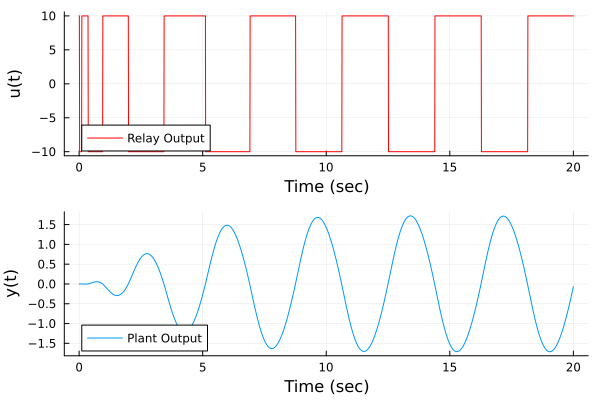

In [6]:
begin
    tvec = collect(0:Ts:20)
    yvec = zeros(size(tvec))
    uvec = zeros(size(tvec))
    numorder = length(Pd_num)
    denorder = length(Pd_den)
    y_prev = zeros(denorder)
    u_prev = zeros(numorder)
    for i in 1:length(tvec)
        for k in 1:denorder-1
            u_prev[k] = u_prev[k+1]
        end
        for k in 1:denorder-1
            y_prev[k] = y_prev[k+1]
        end
        if y_prev[denorder] > 0 #perform relay feedback
            uvec[i] = -d
        else
            uvec[i] = d
        end
        u_prev[numorder] = uvec[i]
        yvec[i] = 0
        for k in 1:denorder-1
            yvec[i] = yvec[i] + Pd_num[k+1]*u_prev[numorder-k]-Pd_den[k+1]*y_prev[denorder-k]
        end
        y_prev[denorder] = yvec[i]
        
    end
    p1 = plot(tvec, uvec, label ="Relay Output", xlabel="Time (sec)", ylabel="u(t)", linecolor=:red, legend=:bottomleft)
    p2 = plot(tvec, yvec, label="Plant Output", xlabel="Time (sec)", ylabel="y(t)", legend=:bottomleft)
    plot(p1,p2,layout=(2,1))
end

In [7]:
#From above, compute Ku = N(a) = 4d/πa , d = 10 , a∼1.6
#Tᵤ ∼ 3.7 s
ku = 40 / (1.6*π)

7.957747154594767

In [8]:
function pid(Kp, Ki, Kd, P, tvec)
    C = Kp + Ki/s + Kd*s
    L = C*P
    T = feedback(L)
    y,t,x = step(T, tvec)
    y = dropdims(y, dims=1)
    r = ones(size(t))
    plot(t,r,label="Step Ref")
    plot!(t,y, label="Plant Output", xlabel="time (sec)", ylabel="y(t)", title="Step response of PID", legend=:bottomright)
end

pid (generic function with 1 method)

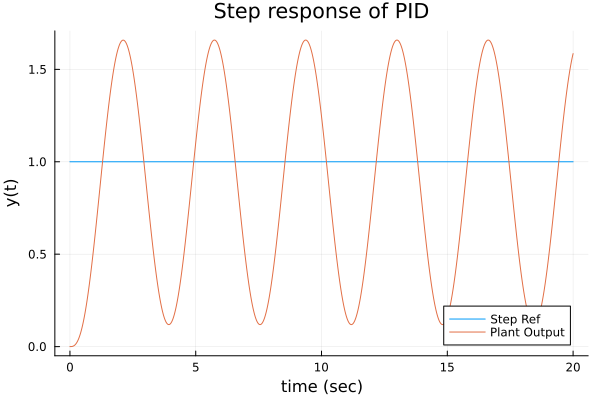

In [10]:
begin
    Kp = 8
    Ki = 0
    Kd = 0
    pid(Kp, Ki, Kd, P, tvec)
end

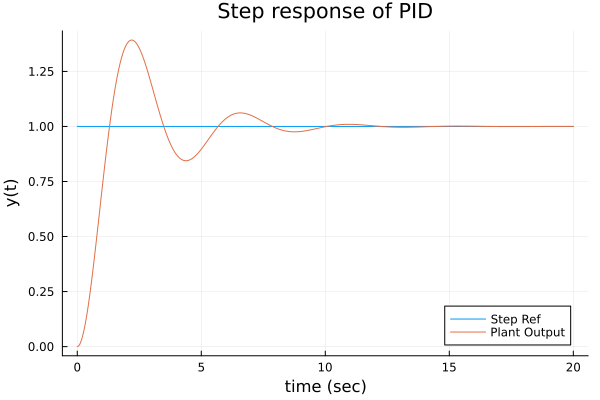

In [13]:
begin
    Ku = 8
    Tu = 3.7
    Kp_zn = 0.6*Ku
    Ki_zn = 1.2*Ku/Tu
    Kd_zn = 0.075*Ku*Tu
    pid(Kp_zn, Ki_zn, Kd_zn, P, tvec)
end 